In [1]:
train_size = 7000
batch_size = 14
z_length = 2000

import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import pandas as pd
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.df = pd.read_csv(csv_file, delimiter=',')
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.df.iloc[idx, 0])
        image = PIL.Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        blink = self.df.iloc[idx, 1]
        return image, blink
    
tensor_transform = transforms.ToTensor()
dataset = Dataset(root_dir = r"prawe_oko_wieksze",
                         csv_file = r"eyes_right.csv",
                         transform = tensor_transform)

train_set, test_set = torch.utils.data.random_split(dataset, [train_size, len(dataset)-train_size])
print('train_set=',len(train_set), 'test_set=', len(test_set))

train_loader = torch.utils.data.DataLoader(dataset = train_set,
                                     batch_size = batch_size,
                                     shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_set,
                                     batch_size = batch_size,
                                     shuffle = True)

cuda
train_set= 7000 test_set= 241


In [2]:
def show_images(images):
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach(), nrow=22).permute(1, 2, 0))

def show_batch(dl):
    for images, _ in dl:
        show_images(images)
        break
        
image_shape = (3, 200, 200)
image_dim = int(np.prod(image_shape))
latent_dim = 100
embedding_dim = 1

# custom weights initialization called on generator and discriminator
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
     
        self.label_conditioned_generator = nn.Sequential(
                      nn.Linear(embedding_dim, 16))
        
    
        self.latent = nn.Sequential(nn.Linear(latent_dim, 4*4*512),
                                   nn.LeakyReLU(0.2, inplace=True))
           

        self.model = nn.Sequential(nn.ConvTranspose2d(513, 64*8, 4, 2, 1, bias=False),
                      nn.BatchNorm2d(64*8, momentum=0.1,  eps=0.8),
                      nn.ReLU(True),
                      nn.ConvTranspose2d(64*8, 64*4, 4, 2, 1,bias=False),
                      nn.BatchNorm2d(64*4, momentum=0.1,  eps=0.8),
                      nn.ReLU(True),
                      nn.Conv2d(64*4, 64*4, 3, 1, 0, bias=False),
                      nn.ReLU(True),
                      nn.ConvTranspose2d(64*4, 64*2, 4, 2, 1,bias=False),
                      nn.BatchNorm2d(64*2, momentum=0.1,  eps=0.8),
                      nn.ReLU(True), 
                      nn.Conv2d(64*2, 64*2, 3, 1, 0, bias=False),
                      nn.ReLU(True),
                      nn.ConvTranspose2d(64*2, 64*1, 4, 2, 1,bias=False),
                      nn.BatchNorm2d(64*1, momentum=0.1,  eps=0.8),
                      nn.ReLU(True), 
                      nn.ConvTranspose2d(64*1, 64, 4, 2, 1, bias=False),
                      nn.ReLU(True), 
                      nn.ConvTranspose2d(64*1, 32, 4, 2, 1, bias=False),
                      nn.ReLU(True),
                      nn.BatchNorm2d(32, momentum=0.1,  eps=0.8),
                      nn.Conv2d(32, 32, 3, 1, 0, bias=False),
                      nn.ReLU(True),
                      nn.Conv2d(32, 32, 3, 1, 0, bias=False),
                      nn.ReLU(True),
                      nn.Conv2d(32, 16, 3, 1, 0, bias=False),
                      nn.ReLU(True),
                      nn.Conv2d(16, 3, 3, 1, 0, bias=False),
                      nn.Sigmoid())

    def forward(self, inputs):
        noise_vector, label = inputs
        label_output = self.label_conditioned_generator(label)
        label_output = label_output.view(-1, 1, 4, 4)
        latent_output = self.latent(noise_vector)
        latent_output = latent_output.view(-1, 512,4,4)
        concat = torch.cat((latent_output, label_output), dim=1)
        image = self.model(concat)
        #print(image.size())
        return image

generator = Generator().to(device)
generator.apply(weights_init)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
    
        self.label_condition_disc = nn.Sequential(
                      nn.Linear(embedding_dim, 3*200*200))
             
        self.model = nn.Sequential(nn.Conv2d(6, 64, 7, 2, 1, bias=False),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64, 64, 7, 3, 2, bias=False),
                      nn.BatchNorm2d(64, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64, 64*2, 5, 3,2, bias=False),
                      nn.BatchNorm2d(64*2, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64*2, 32, 5, 3, 2, bias=False),
                      nn.BatchNorm2d(32, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True), 
                      nn.Flatten(),
                      nn.Dropout(0.4),
                      nn.Linear(512, 1),
                      nn.Sigmoid()
                     )

    def forward(self, inputs):
        img, label = inputs
        label_output = self.label_condition_disc(label)
        label_output = label_output.view(-1, 3, 200, 200)
        concat = torch.cat((img, label_output), dim=1)
        output = self.model(concat)
        return output
    

discriminator = Discriminator().to(device)
discriminator.apply(weights_init)



adversarial_loss = nn.BCELoss() 
def generator_loss(fake_output, label):
    gen_loss = adversarial_loss(fake_output, label)
    #print(gen_loss)
    return gen_loss
def discriminator_loss(output, label):
    disc_loss = adversarial_loss(output, label)
    return disc_loss


learning_rate = 0.0002 
G_optimizer = optim.Adam(generator.parameters(), lr = learning_rate, betas=(0.5, 0.999))
D_optimizer = optim.Adam(discriminator.parameters(), lr = learning_rate, betas=(0.5, 0.999))






In [39]:
model.load_state_dict(torch.load('right_eye_3000'))#continue learning

NameError: name 'model' is not defined

Learn:

In [12]:
num_epochs = 100
D_loss_plot, G_loss_plot = [], []
for epoch in range(1, num_epochs+1): 

    D_loss_list, G_loss_list = [], []
   
    for index, (real_images, labels) in enumerate(train_loader):
        D_optimizer.zero_grad()
        real_images = real_images.to(device)
        labels = labels.to(device)
        labels = labels.unsqueeze(1).float()

      
        real_target = Variable(torch.ones(real_images.size(0), 1).to(device))
        fake_target = Variable(torch.zeros(real_images.size(0), 1).to(device))
      
        D_real_loss = discriminator_loss(discriminator((real_images, labels)), real_target)
        # print(discriminator(real_images))
        #D_real_loss.backward()
    
        noise_vector = torch.randn(real_images.size(0), latent_dim, device=device)  
        noise_vector = noise_vector.to(device)
        
       
        generated_image = generator((noise_vector, labels))
        output = discriminator((generated_image.detach(), labels))
        D_fake_loss = discriminator_loss(output,  fake_target)

    
        # train with fake
        #D_fake_loss.backward()
      
        D_total_loss = (D_real_loss + D_fake_loss) / 2
        D_loss_list.append(D_total_loss)
      
        D_total_loss.backward()
        D_optimizer.step()

        # Train generator with real labels
        G_optimizer.zero_grad()
        G_loss = generator_loss(discriminator((generated_image, labels)), real_target)
        G_loss_list.append(G_loss)

        G_loss.backward()
        G_optimizer.step()


    print('Epoch: [%d/%d]: D_loss: %.3f, G_loss: %.3f' % (
            (epoch), num_epochs, torch.mean(torch.FloatTensor(D_loss_list)),
             torch.mean(torch.FloatTensor(G_loss_list))))
    
    D_loss_plot.append(torch.mean(torch.FloatTensor(D_loss_list)))
    G_loss_plot.append(torch.mean(torch.FloatTensor(G_loss_list)))
    save_image(generated_image.data[:50], 'sample_%d'%epoch + '.png', nrow=5, normalize=True)
     
    torch.save(generator.state_dict(), 'generator_epoch.pth')
    torch.save(discriminator.state_dict(), 'discriminator_epoch.pth')
    

Epoch: [1/100]: D_loss: 0.378, G_loss: 2.372
Epoch: [2/100]: D_loss: 0.372, G_loss: 2.412
Epoch: [3/100]: D_loss: 0.372, G_loss: 2.376
Epoch: [4/100]: D_loss: 0.397, G_loss: 2.343
Epoch: [5/100]: D_loss: 0.396, G_loss: 2.343
Epoch: [6/100]: D_loss: 0.392, G_loss: 2.318
Epoch: [7/100]: D_loss: 0.394, G_loss: 2.301
Epoch: [8/100]: D_loss: 0.391, G_loss: 2.380
Epoch: [9/100]: D_loss: 0.395, G_loss: 2.343
Epoch: [10/100]: D_loss: 0.404, G_loss: 2.310
Epoch: [11/100]: D_loss: 0.392, G_loss: 2.306
Epoch: [12/100]: D_loss: 0.397, G_loss: 2.331
Epoch: [13/100]: D_loss: 0.395, G_loss: 2.342
Epoch: [14/100]: D_loss: 0.376, G_loss: 2.391
Epoch: [15/100]: D_loss: 0.381, G_loss: 2.380
Epoch: [16/100]: D_loss: 0.395, G_loss: 2.351
Epoch: [17/100]: D_loss: 0.378, G_loss: 2.302
Epoch: [18/100]: D_loss: 0.373, G_loss: 2.425
Epoch: [19/100]: D_loss: 0.412, G_loss: 2.325
Epoch: [20/100]: D_loss: 0.392, G_loss: 2.339
Epoch: [21/100]: D_loss: 0.378, G_loss: 2.380


KeyboardInterrupt: 

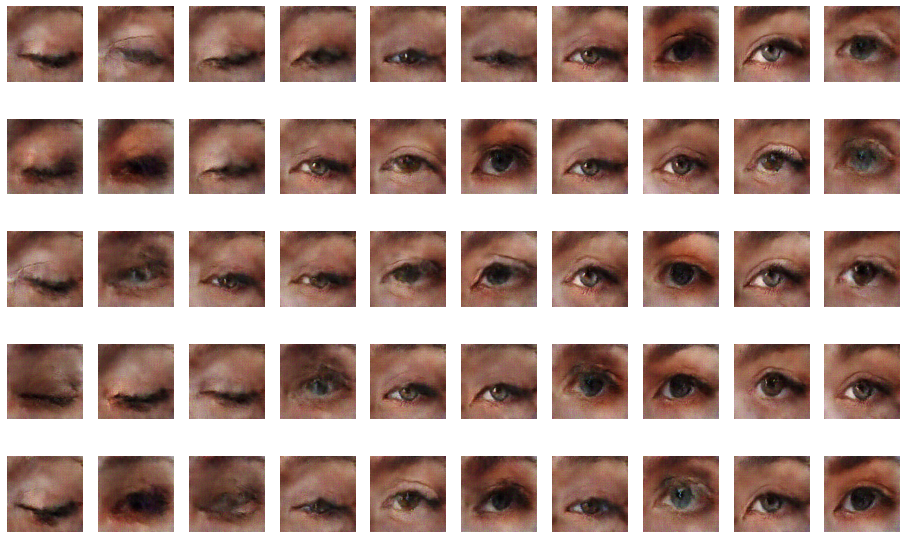

In [13]:
fig = plt.figure(figsize=(16, 10))
for i in range(10):
    noise_vector = torch.randn(5, latent_dim, device=device)
    noise_vector = noise_vector.to(device).float()
    for j in range(5):
        label = transforms.ToTensor()(np.array([i/40+0.1]).reshape(-1,1))
        label = label.to(device).float()
        sample = generator((noise_vector[j].float(), label.float()))[0].cpu().detach().numpy()
        sample = sample.swapaxes(0, 1)
        sample = sample.swapaxes(1, 2)
        ax = plt.subplot(5, 10, j*10 + i+1)
        ax.axis('off')
        plt.imshow(sample)